In [1]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import asarray

from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


In [2]:
def alphaT(El,Ep,Thl,Thp,Phl,Php,pid='electron'):
    MuMass = 105.6584
    EMass = 0.511
    PMass  = 938.2721
    if pid == 'electron':
        Pl  = sqrt((El+EMass)**2  - EMass**2)
    elif pid == 'muon':
        Pl  = sqrt((El+MuMass)**2  - MuMass**2)
    Pp  = sqrt((Ep+PMass)**2 - PMass**2)
    Plt = [Pl*sin(Thl)*cos(Phl),Pl*sin(Thl)*sin(Phl),0]
    Ppt = [Pp*sin(Thp)*cos(Php),Pp*sin(Thp)*sin(Php),0]
    PltM = sqrt(Plt[0]**2+Plt[1]**2)
    PptM = sqrt(Ppt[0]**2+Ppt[1]**2)
    Pt  = [Ppt[0]+Plt[0],Ppt[1]+Plt[1],0]
    PtMag = sqrt(Pt[0]**2 + Pt[1]**2)
    if PltM == 0 or PptM == 0:
        return 9999
    try:
        alphat = acos(-1.0*(Plt[0]*Pt[0]+Plt[1]*Pt[1])/(PtMag*PltM))
    except:
        alphat = -999
    return alphat

In [3]:
def alphaTFromP(Pl,Pp,vecl,vecp,pid='electron'): 

    Plt = [Pl*vecl[0],Pl*vecl[1],0]
    Ppt = [Pp*vecp[0],Pp*vecp[1],0]
    PltM = sqrt(Plt[0]**2+Plt[1]**2)
    PptM = sqrt(Ppt[0]**2+Ppt[1]**2)
    Pt  = [Ppt[0]+Plt[0],Ppt[1]+Plt[1],0]
    PtMag = sqrt(Pt[0]**2 + Pt[1]**2)
    if PltM == 0 or PptM == 0:
        return 9999
    try:
        alphat = acos(-1.0*(Plt[0]*Pt[0]+Plt[1]*Pt[1])/(PtMag*PltM))
    except:
        alphat = -999
    return alphat

In [4]:
proton_mom = 0.758019
lepton_mom = 0.303
proton_vec = np.array((-0.242911,-0.0678075,0.967676))
lepton_vec = np.array((0.284908,-0.405149,-0.868724))

alphat = alphaTFromP(lepton_mom,proton_mom,lepton_vec,proton_vec)
print(alphat)

2.0170220924077067


In [5]:
vtx = np.array((239.84718,-100.3157,818.2999))
p1_endpt = np.array((241.5999,-100.1646,815.24486))
p1_lepE = 25.65
p1_proE = 64.773
p2_endpt = np.array((236.92262,-85.43641,873.62341))
p2_lepE = 173.29
p2_proE = 342.81259

MuMass = 105.6584
PMass  = 938.2721

p1_lepMom =sqrt((p1_lepE+MuMass)**2  - MuMass**2)
p2_lepMom =sqrt((p2_lepE+MuMass)**2  - MuMass**2)
p1_proMom =sqrt((p1_proE+PMass)**2  - PMass**2)
p2_proMom =sqrt((p2_proE+PMass)**2  - PMass**2)

p1vec = p1_endpt-vtx
p1vecmag = sqrt(p1vec[0]**2 + p1vec[1]**2 + p1vec[2]**2)
p1uvec = p1vec/p1vecmag
print('p1uvec:',p1uvec)

p2vec = p2_endpt-vtx
p2vecmag = sqrt(p2vec[0]**2 + p2vec[1]**2 + p2vec[2]**2)
p2uvec = p2vec/p2vecmag
print('p2uvec:',p2uvec)

alphat1 = alphaTFromP(p1_lepMom,p2_proMom,p1uvec,p2uvec)
print('p1 lepton momentum:',p1_lepMom,'p2 proton momentum:',p2_proMom)
print('If p1 is lepton, alphat: ',alphat1)
print('if alphat is flipped...: ',np.abs(alphat1-np.pi))

alphat2 = alphaTFromP(p2_lepMom,p1_proMom,p2uvec,p1uvec)
print('p2 lepton momentum:',p2_lepMom,'p1 proton momentum:',p1_proMom)
print('If p2 is lepton, alphat: ',alphat2)
print('if alphat is flipped...: ',np.abs(alphat2-np.pi))


p1uvec: [ 0.49717546  0.04286093 -0.86659074]
p2uvec: [-0.05098243  0.25938342  0.96442783]
p1 lepton momentum: 77.96280151456848 p2 proton momentum: 872.2519414217353
If p1 is lepton, alphat:  1.6319344508542437
if alphat is flipped...:  1.5096582027355494
p2 lepton momentum: 258.1637317130352 p1 proton momentum: 354.60532849296004
If p2 is lepton, alphat:  1.8432667488300352
if alphat is flipped...:  1.298325904759758


If p1 is lepton, alphat:  0.09123305881364281


In [6]:
alphat2 = alphaTFromP(p2_lepMom,p1_proMom,p2uvec,p1uvec)
print('If p2 is lepton, alphat: ',alphat2)

If p2 is lepton, alphat:  1.8432667488300352


In [7]:
df_data_presel = pd.read_parquet('../data/pickles/data_goodruns_precuts_Feb21-final.parquet')

In [8]:
df_data_presel[['run','subrun','event','Xreco','Muon_Edep','Proton_Edep','AlphaT_1m1p']]

,run,subrun,event,Xreco,Muon_Edep,Proton_Edep,AlphaT_1m1p
315,5121,33,1671,178.003265,164.691574,120.263252,3.086065
351,5121,34,1750,239.847183,173.294205,64.773453,1.799216
365,5121,35,1780,56.134502,141.043747,110.385956,0.094037
370,5122,1,63,91.563278,73.946159,55.309380,0.673878
375,5122,1,78,46.490597,290.768829,531.953430,0.067628
...,...,...,...,...,...,...,...
243148,5946,73,3674,224.778931,98.920059,76.231102,0.768607
243177,5946,77,3899,211.422791,193.419250,53.248669,1.819821
243194,5946,79,3996,193.228104,41.933353,46.878769,0.348693
243204,5946,81,4090,77.793297,238.656372,79.507301,3.034913


In [9]:
def bless_tune1_reweight(row):
    rw = float(1)
    if row['nu_interaction_mode']==1001 and (row['nu_pdg']==14 or row['nu_pdg']==-14):
        rw = xsec_tune1_graph_numu.Eval(row['MC_energyInit']) / xsec_mcc9_graph_numu.Eval(row['MC_energyInit'])
    if row['nu_interaction_mode']==1001 and (row['nu_pdg']==12 or row['nu_pdg']==-12):
        rw = xsec_tune1_graph_nue.Eval(row['MC_energyInit']) / xsec_mcc9_graph_nue.Eval(row['MC_energyInit'])
    return rw

def bless_MC_labels(row):
    mclabel = ''
    intlabel = ''
    parentlabel = ''
    pizero = [1090,1086,1090,1080,1015,1013,1011,1008,1006,1004]
    piplusminus = [1085,1079,1032,1017,1014,1007,1005,1003,1028,1021,1016,1012,1010,1009]
        
    if abs(row['nu_pdg']) == 12:
        intlabel = 'nue'
    elif abs(row['nu_pdg']) == 14:
        intlabel = 'numu'
    
    if not 0 < row['MC_scedr'] <= 5.0 :
        mclabel = 'offvtx'
    else:
        if row['nu_interaction_type'] == 1001:
            mclabel = 'CCQE'
        elif row['nu_interaction_type'] == 1000:
            mclabel = 'MEC'
        elif row['nu_interaction_type'] in pizero:
            mclabel = 'pizero'
        elif row['nu_interaction_type'] in piplusminus:
            mclabel = 'piplusminus' 
        else:
            mclabel = 'other'
            
    return '%s_%s'%(intlabel,mclabel)

In [10]:
df_bnb = read_root('../data/mcc9_v13_bnb_overlay/FVV-AlphaT-Mar24SAMPLE.root')
df_bnb_cvweight = read_root('../data/mcc9_v13_bnb_overlay/weights_forCV_v33_bnb_nu_run1.root')

print('Loaded Files')
RSE=['run','subrun','event']

df_bnb = df_bnb.join(df_bnb_cvweight.set_index(RSE)[['nu_interaction_mode','nu_interaction_type','xsec_corr_weight','spline_weight','nu_interaction_ccnc','nu_pdg']],on=RSE)

# remove nue cc events
df_numu = df_bnb.query('not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_goodruns_precuts = df_numu.query("PassPMTPrecut==1 and PassSimpleCuts==1")

print('Merged')

df_numu_goodruns_precuts.insert(0,'xsec_tune1_weight',df_numu_goodruns_precuts.apply(bless_tune1_reweight,axis=1))

print('Genie Reweighted')

df_numu_goodruns_precuts.insert(0,'mc_label',df_numu_goodruns_precuts.apply(bless_MC_labels,axis=1))

print ('MC Labeled')

Loaded Files
Merged
Genie Reweighted
MC Labeled


In [11]:
df_ccqe = df_numu_goodruns_precuts.query("mc_label in ['numu_CCQE']")

In [18]:
df_ccqe

,mc_label,xsec_tune1_weight,run,subrun,event,vtxid,Xreco,Yreco,Zreco,InFiducial,...,MC_nlepton,MC_alphaT,MC_parentSCEX,MC_scedr,nu_interaction_mode,nu_interaction_type,xsec_corr_weight,spline_weight,nu_interaction_ccnc,nu_pdg
36,numu_CCQE,1.0,5600,7,352,0,43.461765,8.311600,366.950012,1,...,1,2.221200,43.590588,0.238302,0,1001,1.256738,1.023208,0,14
220,numu_CCQE,1.0,5600,66,3348,0,154.777054,-83.179909,112.150002,1,...,1,3.025057,154.473160,0.543155,0,1001,1.919916,1.479740,0,14
237,numu_CCQE,1.0,5600,69,3471,0,39.842133,-92.647346,591.950012,1,...,1,3.127800,39.645916,0.326838,0,1001,1.220870,0.977176,0,14
284,numu_CCQE,1.0,5600,72,3609,1,74.366127,-62.182869,556.250000,1,...,1,2.196862,74.090935,0.354082,0,1001,1.389241,1.121074,0,14
391,numu_CCQE,1.0,5600,116,5846,0,86.190910,70.838638,864.549988,1,...,1,-1.000000,85.829308,0.490307,0,1001,1.236399,0.964751,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613760,numu_CCQE,1.0,7498,256,12828,0,176.231201,-7.044806,905.250000,1,...,1,2.395296,176.164932,0.902040,0,1001,1.156276,0.964947,0,14
613769,numu_CCQE,1.0,7498,129,6497,1,38.722134,63.697994,889.549988,1,...,1,2.255917,39.362080,1.038694,0,1001,3.477662,1.920003,0,14
613824,numu_CCQE,1.0,7498,208,10439,0,21.008337,29.308645,203.149994,1,...,1,2.141278,20.701141,0.473820,0,1001,1.639504,1.382961,0,14
613911,numu_CCQE,1.0,7499,73,3689,0,133.190521,-7.989292,410.549988,1,...,1,2.650597,133.226624,0.338299,0,1001,1.238963,1.011782,0,14


In [11]:
df_ccqe.query('abs(AlphaT_1m1p - AlphaTpure) > 1.6')

,mc_label,xsec_tune1_weight,run,subrun,event,vtxid,Xreco,Yreco,Zreco,InFiducial,...,MC_nlepton,MC_alphaT,MC_parentSCEX,MC_scedr,nu_interaction_mode,nu_interaction_type,xsec_corr_weight,spline_weight,nu_interaction_ccnc,nu_pdg
36,numu_CCQE,1.0,5600,7,352,0,43.461765,8.311600,366.950012,1,...,1,2.221200,43.590588,0.238302,0,1001,1.256738,1.023208,0,14
237,numu_CCQE,1.0,5600,69,3471,0,39.842133,-92.647346,591.950012,1,...,1,3.127800,39.645916,0.326838,0,1001,1.220870,0.977176,0,14
624,numu_CCQE,1.0,5600,155,7794,0,145.527542,53.537743,191.550003,1,...,1,2.012238,145.406448,0.318645,0,1001,1.284945,0.994347,0,14
647,numu_CCQE,1.0,5600,165,8293,1,162.413879,40.027744,646.049988,1,...,1,0.426517,162.098785,0.491355,0,1001,1.201927,0.975401,0,14
681,numu_CCQE,1.0,5601,2,107,0,44.054256,-103.838692,725.400024,1,...,1,-1.000000,43.958260,0.417737,0,1001,1.333497,1.025243,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613087,numu_CCQE,1.0,7487,134,6736,2,64.362854,13.046983,336.950012,1,...,1,-1.000000,64.787560,0.501898,0,1001,1.245170,1.066805,0,14
613243,numu_CCQE,1.0,7491,47,2378,0,73.498283,6.945575,832.250000,1,...,1,-1.000000,73.525009,0.555129,0,1001,1.201020,0.984428,0,14
613769,numu_CCQE,1.0,7498,129,6497,1,38.722134,63.697994,889.549988,1,...,1,2.255917,39.362080,1.038694,0,1001,3.477662,1.920003,0,14
613911,numu_CCQE,1.0,7499,73,3689,0,133.190521,-7.989292,410.549988,1,...,1,2.650597,133.226624,0.338299,0,1001,1.238963,1.011782,0,14


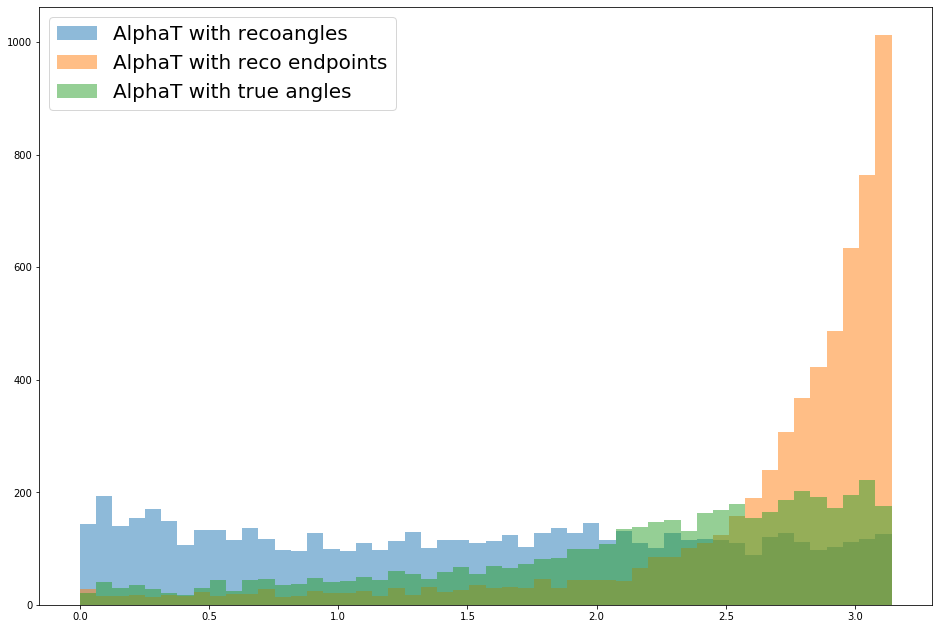

In [24]:
var_ccqe = df_ccqe.query('Good3DReco == 1')['AlphaT_1m1p'].values
var_ccqe_pure = df_ccqe.query('Good3DReco == 1')['AlphaTpure'].values
var_ccqe_tru = df_ccqe.query('Good3DReco == 1')['MC_alphaT'].values

wgts_ccqe = df_ccqe.query('Good3DReco == 1')['xsec_corr_weight'].values

fig,ax = plt.subplots(figsize=(16,11))
_ = plt.hist(var_ccqe,50,(0,np.pi),alpha=.5,label='AlphaT with recoangles',weights=wgts_ccqe)
_ = plt.hist(var_ccqe_pure,50,(0,np.pi),alpha=.5,label='AlphaT with reco endpoints',weights=wgts_ccqe)
_ = plt.hist(var_ccqe_tru,50,(0,np.pi),alpha=.5,label='AlphaT with true angles',weights=wgts_ccqe)

plt.legend(fontsize=20)

1.012719112093773
1.0239140588936164
1.0009069687038852
1.0007602110395877


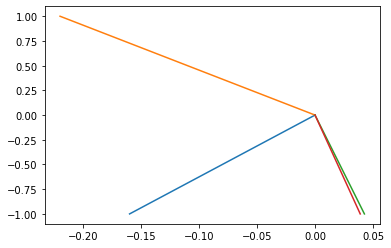

In [15]:
V = ([-0.16,-1],[-.22,1],[0.0426,-1],[0.039,-1])

for v in V:
    plt.plot([0,v[0]],[0,v[1]])
    print(np.sqrt(v[0]**2+v[1]**2))

plt.show()